# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import time
from tqdm import tqdm

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score

from scipy.interpolate import interp1d
from scipy.integrate import quad
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.linear_model import SGDClassifier, ElasticNetCV, LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFECV
from catboost import CatBoostClassifier, CatBoostRegressor
#from xgboost import XGBRFClassifier, XGBRegressor, XGBRFRegressor


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [3]:
PATH = "./data/"

In [4]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')
insur_test_data = pd.read_csv(os.path.join(PATH, 'porto', 'test.csv')).set_index('id')

In [5]:
insurance_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [6]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [7]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [10]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

0.9631224658945812

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

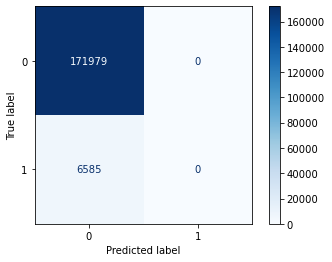

In [11]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [12]:
insurance_data.describe()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

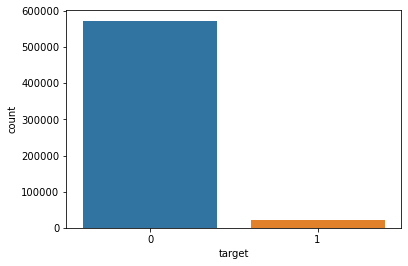

In [13]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [14]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

*Построим графики кривых ROC и Gini предсказанных значений и валидационных (т.е. идеальном предсказании модели).
Построение графиков взято отсюда: https://habr.com/ru/company/ods/blog/350440/*

In [15]:
y_pred = clf.predict_proba(X_valid)[:, 1]

<ipython-input-16-5e0a3d853cc6>:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  S_pred = quad(f1, 0, 1, points=10)[0] - 0.5


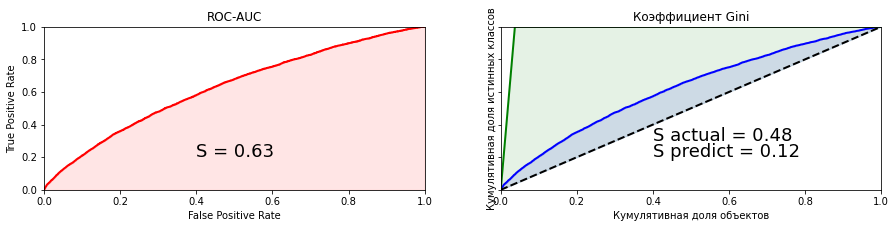

In [16]:
aucroc = roc_auc_score(y_valid, y_pred)
#gini = 2*roc_auc_score(y_valid, y_pred)-1
gini_norm = gini_normalized(y_valid, y_pred)
fpr, tpr, t = roc_curve(y_valid, y_pred)


data = zip(y_valid, y_pred)
sorted_data = sorted(data, key=lambda d: d[1], reverse=True)
sorted_actual = [d[0] for d in sorted_data]

cumulative_actual = np.cumsum(sorted_actual) / sum(y_valid)
cumulative_index = np.arange(1, len(cumulative_actual)+1) / len(y_pred)
cumulative_actual_perfect = np.cumsum(sorted(y_valid, reverse=True)) / sum(y_valid)
x_values = [0] + list(cumulative_index)
y_values = [0] + list(cumulative_actual)
y_values_perfect = [0] + list(cumulative_actual_perfect)
f1, f2 = interp1d(x_values, y_values), interp1d(x_values, y_values_perfect)
S_pred = quad(f1, 0, 1, points=10)[0] - 0.5
S_actual = quad(f2, 0, 1, points=10)[0] - 0.5

fig, ax = plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(15, 3))
#fig.suptitle('Gini = 2 * AUCROC - 1 = {:0.2f}\n\n'.format(gini),fontsize = 18, fontweight='bold')
ax[0].plot([0]+fpr.tolist(), [0]+tpr.tolist(), lw = 2, color = 'red')
ax[0].fill_between([0]+fpr.tolist(), [0]+tpr.tolist(), color = 'red', alpha=0.1)
ax[0].text(0.4,0.2,'S = {:0.2f}'.format(aucroc),fontsize = 18)
ax[1].plot(x_values, y_values, lw = 2, color = 'blue')
ax[1].fill_between(x_values, x_values, y_values, color = 'blue', alpha=0.1)
ax[1].text(0.4,0.2,'S predict = {:0.2f}'.format(S_pred),fontsize = 18)
ax[1].plot(x_values, y_values_perfect, lw = 2, color = 'green')
ax[1].fill_between(x_values, x_values, y_values_perfect, color = 'green', alpha=0.1)
ax[1].text(0.4,0.3,'S actual = {:0.2f}'.format(S_actual),fontsize = 18)

ax[0].set(title='ROC-AUC', xlabel='False Positive Rate', 
              ylabel='True Positive Rate', xlim=(0, 1), ylim=(0, 1))
for i in range(1,2):
    ax[i].plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    ax[i].set(title='Коэффициент Gini', xlabel='Кумулятивная доля объектов', 
              ylabel='Кумулятивная доля истинных классов', xlim=(0, 1), ylim=(0, 1))
plt.show();

Под нормализованным коэффициентом Gini подразумевается отношение предсказанной площади ($S_p$) между **синей** кривой и диагональю от 0 до 1 к площади истинного (или идеально предсказанного $S_a$)) обозначенного **зеленым**. Т.е.:
$$Gini = S_p/(S_a+S_p)$$
Т.к. значение площади $S_a+S_p$ близко к значению площади треугольника заключенного между осью X,Y и диагональю от 0 до 1, то примем это значение равным 0,5.
$$S_a+S_p=0,5$$
Подставив данное значение в формулу коэффициента получим:
$$Gini = S_p/0,5=2S_p$$
В свою очередь площадь ROC-AUC можно представить формулой:
$$AUC = S_p + 0,5$$
т.к. площадь между диагональю от 0 до 1 и осями графика также равна половине площади квадрата со стороной 1, а часть площади между диагональю и кривой по значению близка $S_p$ (это видно на графике).
Выведем из вышеуказанной формулы значение $S_p$ и подставим в коэффициент Gini:
$$S_p = AUC - 0,5$$
$$Gini = 2S_p = 2(AUC - 0,5)=2AUC-1$$


**(0.5 points)** By the way, what other metrics could you suggest for this problem?

*Возможно для решения данной проблемы можно отбросить часть данных одного класса, чтобы примерно уравнять количество данных с классом 1 и классом 0. 
Также можно попробовать использовать другую метрику точности, предназначенную для такого вида данных.*


Let's calculate the Normalized Gini Coefficient:

In [17]:
gini_normalized(y_valid, y_pred)

0.2558723581569817

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [18]:
print('Процент целевого показателя target со значением 1 в датасете: {:.1%}'.format(insurance_data[insurance_data['target'] == 1]['target'].count()/
                                                                                insurance_data['target'].count()))

Процент целевого показателя target со значением 1 в датасете: 3.6%


*Метод №1 under- и over-sampling*

In [19]:
# Class count
count_class_0, count_class_1 = insurance_data['target'].value_counts()

# Divide by class
df_class_0 = insurance_data[insurance_data['target'] == 0]
df_class_1 = insurance_data[insurance_data['target'] == 1]

In [20]:
#Random under-sampling
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.target.value_counts())

Random under-sampling:
0    21694
1    21694
Name: target, dtype: int64


In [21]:
#Random over-sampling
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.target.value_counts())

Random over-sampling:
0    573518
1    573518
Name: target, dtype: int64


*Метод №2 under- и over-sampling при помощи библиотеки imblearn*

In [22]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [23]:
random_smplr = RandomUnderSampler(random_state=0, replacement=True) 

In [24]:
X_undr, y_undr = random_smplr.fit_resample(insurance_data.drop(columns=['target']), insurance_data['target'])

In [25]:
over_smplr = RandomOverSampler()

In [26]:
X_over, y_over = over_smplr.fit_resample(insurance_data.drop(columns=['target']), insurance_data['target'])

In [27]:
y = df_test_over['target']
X = df_test_over.drop(columns=['target'])

In [28]:
#y = y_over
#X = X_over

In [29]:
categorical_features = [cname for cname in X.columns if
                    X[cname].dtype == "object"]
numeric_features = [cname for cname in X.columns if 
                X[cname].dtype in ['int64', 'float64']]

In [30]:
params = {'n_estimators': 1000, 'max_depth': 10,
                'criterion':"entropy", 'max_features': 4,
                'n_jobs': -1, 'random_state': 0}

In [31]:
#numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

#categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
#categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        #('cat', categorical_transformer, categorical_features)
    ])

#selector = SelectFromModel(RandomForestRegressor(n_estimators=300))
selector = SelectFromModel(LogisticRegression(penalty='l2', solver='liblinear'))


#model = KNeighborsClassifier(n_neighbors=8, weights='distance', n_jobs=-1)
#model = SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14)
#model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=500) #private score 0.18810
#model = RandomForestClassifier(n_estimators=1000, max_depth=10, criterion='entropy', 
#                               max_features=4, n_jobs=-1, random_state=0)
model = CatBoostClassifier(task_type='GPU', random_state=0, verbose=100)

In [32]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('selector', selector),
                           ('model', model)])

In [33]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)

In [34]:
def acc_score(depth):
    preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])
    selector = SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear'))
    #model = RandomForestClassifier(n_estimators=1000, criterion="entropy", max_features=max_features,
    #                               max_depth=10, n_jobs=-1, random_state=0)
    model = CatBoostClassifier(n_estimators=1800, task_type='GPU', depth=depth, random_state=0, verbose=100)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               #('selector', selector),
                               ('model', model)])
    accur = cross_val_score(pipeline,X_train, y_train, cv = 5)
    return(accur)

In [35]:
#metrics = [10, 12]
#results = {}
#for x in tqdm(metrics):
#    results[x] = acc_score(x).mean()

In [36]:
#sns.lineplot(data=results)

In [37]:
#results

In [38]:
clf = pipeline.fit(X_train, y_train)

Learning rate set to 0.023335
0:	learn: 0.6921913	total: 31.3ms	remaining: 31.3s
100:	learn: 0.6651011	total: 1.33s	remaining: 11.8s
200:	learn: 0.6596969	total: 2.54s	remaining: 10.1s
300:	learn: 0.6563424	total: 3.72s	remaining: 8.65s
400:	learn: 0.6535440	total: 4.96s	remaining: 7.4s
500:	learn: 0.6509737	total: 6.13s	remaining: 6.1s
600:	learn: 0.6486317	total: 7.39s	remaining: 4.91s
700:	learn: 0.6463027	total: 8.65s	remaining: 3.69s
800:	learn: 0.6439411	total: 9.86s	remaining: 2.45s
900:	learn: 0.6417579	total: 11.1s	remaining: 1.22s
999:	learn: 0.6397323	total: 12.2s	remaining: 0us


In [39]:
clf.score(X_valid, y_valid)

0.6259579031184705

In [40]:
#cross_val_score(clf, X_valid, y_valid, cv=3)

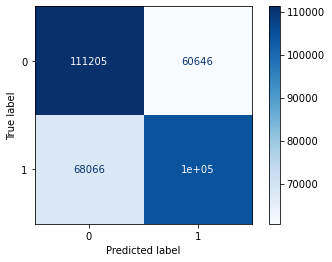

In [41]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

In [42]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [43]:
gini_normalized(y_valid, y_pred), roc_auc_score(y_valid, y_pred)

(0.3618426031226903, 0.6809213014265949)

In [44]:
insurance_pred = clf.predict(insur_test_data)

In [45]:
submission_porto = pd.DataFrame({
        "Id": insur_test_data.index,
        "Target": insurance_pred
    })
submission_porto.to_csv('submission_porto.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


***Private Score: 0.19359 (with CatBoost)***

![Prediction_Kaggle.png](attachment:Prediction_Kaggle.png)

In [46]:
y_bonus = round(200 * max(0.19359 - 0.253, 0))/2

In [47]:
print('My bonus score = {}'.format(y_bonus))

My bonus score = 0.0
